## Time-Dependency of Calculated Growth Rate

Figure 2 determines how calculated growth rate changes depending on which timepoint is used while fitting change in sgRNA frequency over time. It shows that generally growth rate decreases with time, but that some sgRNAs show fluctuations in growth rate over the course of the experiment. As the effect that time may have on growth rate for certain guides varies, a linear fit across all measured timepoints is most accurate in estimating a relative growth rate of cells expressing each guide. This analysis can visualize these relationships in glucose or in glycerol, and focuses on the effects of the on-target SG1, as this guide by design is the most likely to have a strong effect on growth rate.

6/29/20

Written by Andrew D. Mathis
Edited by Ryan Otto

## Import useful libraries

In [8]:
import pickle # Moving data
import pandas as pd # Data organization
import numpy as np # Data organization
from scipy import stats # For linear regression and sem calculations
from scipy.cluster.hierarchy import dendrogram, linkage # Linkage analysis
import seaborn as sns # Heatmap plotting function
import matplotlib.pyplot as plt # Plotting function
# Renders figures in notebook
%matplotlib inline

## Establish all paths and variables unique to this analysis.

Default values to recreate figures are provided.

In [9]:
# Establish file paths
turb_path = 'inputs/20200203_turb_growth.pickle' # Path to culture growth rate information
pickle_path = 'pickle/' # General path for all intermediate data frames saved as *.pickle
output_path = 'outputs/' # General path for output data saved as .csv
figure_path = 'Figures/' # General path for saving figures

# Select media to analyze
media = 'Glu'

# Sequencing data timepoints
# Note: No 8 hour timepoint was taken in either media condition, and two glycerol timepoints (4 and 12 hours)
# were excluded to allow for sufficient sequencing depth
TPs = {}
TPs['Glu'] = np.array([0, 2, 4, 6, 10, 12, 14])
TPs['Gly'] = np.array([0, 2, 6, 10, 14])

# Keys in turbidostat growth data for each media condition
turb_lib = {}
turb_lib['Glu'] = 'Glu-lib-1'
turb_lib['Gly'] = 'Gly-lib-2'

# sgRNA that causes near death effects on growth to use for normalization
death_norm = 'gyrB_2_101_C' # Based on previous work

# Date stamp on all outputs
date = '20200923'

# Central Functions for Analysis

## Calculating growth rates from individual timepoints

These functions estimate growth rate by calculating the slope of the relative frequency vs time line from T0 to each subsequent timepoint. As this slope can change over time, ANOVA is utilized to test the hypothesis that the growth rate is constant, regardless of the timepoint used to calculate it. A low p-value from this test suggests that the calculated growth rate will vary based on which timepoint or series of timepoints is included in the slope calculation.

In [10]:
# Calculates the slope of relative frequency vs time of all genes. In theory, all timepoints should fall on the same
# line, but this calculates the slope between T0 and every timepoint individually. As a reminder, the slope of the
# relative frequency vs time plot is the growth rate relative to negC (WT growth control).
# Input -- df_normed: Data frame of counts normalized by negC_rand_42, normalized by T0, and log2 transformed
#          df_BC: Data frame of counts organized by barcode
#          TPs: Timepoint of each measurement
#          turb_growth: Contains scaling factor for exact timepoints
#          turb_lib: Contains keys for turbidostat growth data
# Output -- df_singles: Data frame of growth rate calculated from the slope of T0 to a single later timepoint
def TP_growth(df_normed, df_BC, TPs, media, turb_growth, turb_lib):
    
    # Initialize dictionary for single timepoint growth rate data
    singles_dict = {}
    for i in range(len(df_normed['AGTCTA'].keys())):
        singles_dict[i] = {}
    TPs_new = TPs[media]*turb_growth[turb_lib[media]] # Exact timepoints

    for BC in df_normed.keys(): # For all replicates
        for guide in df_normed[BC].index: # For all guides
            if '_1_' in guide and '_C' in guide: # Look only at SG1 parent guides
                y = df_normed[BC].loc[guide].values # Pull out all growth rate data
                yc = df_BC[BC].loc[guide].values # Pull out all count data

                for i, j in enumerate(singles_dict.keys()):
                    if yc[i] <= 10 and i > 0: # Avoid fitting timepoints after a point with 10 counts or fewer
                        y_new = [y[0], y[i]]
                        TPs_fit = [TPs_new[0], TPs_new[i]]
                        # Slope of relative frequency vs time from T=0 to T=TPs_new[i]
                        m = (y[i] - y[0]) / (TPs_new[i] - TPs_new[0]) 
                        if guide not in singles_dict[i].keys(): # Initialize for first instance of a guide.
                            singles_dict[i][guide] = []
                            singles_dict[i][guide].append(float(round(m, 3)))
                        else:
                            singles_dict[i][guide].append(float(round(m, 3)))
                        break
                    elif str(y[i]) != 'nan' and i > 0: 
                        y_new = [y[0], y[i]]
                        TPs_fit = [TPs_new[0], TPs_new[i]]
                        # Slope of relative frequency vs time from T=0 to T=TPs_new[i]
                        m = (y[i] - y[0]) / (TPs_new[i] - TPs_new[0]) 
                        if guide not in singles_dict[i].keys(): # Initialize for first instance of a guide.
                            singles_dict[i][guide] = []
                            singles_dict[i][guide].append(float(round(m, 3)))
                        else:
                            singles_dict[i][guide].append(float(round(m, 3)))

    # Takes growth rate data and puts it into a dataframe
    df_singles = pd.DataFrame.from_dict(singles_dict)
    df_singles.columns = TPs_new
    df_singles = df_singles.drop(0, axis='columns')
    
    return df_singles


# Runs one-way ANOVA testing the null hypothesis that data from all successfully measured timepoints for a given guide
# result in the same growth rate.
# Input -- df_singles: Data frame of growth rate calculated from the slope of T0 to a single later timepoint
# Output -- df_singles['p-value']: Extra column containing the p-value testing the null that every growth rate is 
#                                  equal regardless of the timepoint used to calculate them
def TP_ANOVA(df_singles):
    
    # Initialize list to hold all p-values from ANOVA testing
    p_value = []

    for guide in df_singles.index: # For all guides
        growth_rates = df_singles.loc[guide].to_numpy() # All growth rate replicate calculations
        index_not_nan = [] # Index for arrays that aren't nan to filter out prior to ANOVA
        for i, growth_array in enumerate(growth_rates): # i is the TP index and array is all replicate growth rates
            if i > 1: # Need two timepoints after T0 to compare growth rates between timepoints
                if type(growth_array) == list: # Multiple points
                    if any(np.isnan(np.hstack(growth_array))) != True: # Filter nans
                        index_not_nan.append(i)
        if len(index_not_nan) >= 2: # Quality data collected from at least 2 replicates
            fval, pval = stats.f_oneway(*growth_rates[index_not_nan]) # ANOVA testing if all growth rates are equal
        else:
            pval = np.nan

        if pval < 0.001: # p-values less than 0.001 indicate a difference in growth rate
            pval = 0.001
        p_value.append(pval)

    # Adds p-values to the df_singles data frame
    df_singles['p-value'] = p_value

    # Plots p-values from ANOVA testing dependence of relative growth rate on the timepoint used to calculate it
    plt.figure(figsize = (8, 4))
    bins = np.logspace(-3, 0, 10)
    mask = ~np.isnan(p_value) # Ignore nan p-values from guides with too few measurements
    plt.hist(df_singles['p-value'][mask], bins=bins)
    plt.xscale('log')
    plt.title('Using different times points for calculating fitness yields different results', fontsize=14)
    plt.xlabel('p-value from ANOVA accross timepoints', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return df_singles['p-value']


## Plotting individual timepoint growth rates

These plotting functions visualize earlier results. The TP_plots function compares the calculated growth rate from each individual timepoint as well as the result of a linear fit from all timepoints. The function can normalize growth rate to be relative to that calculated at the first timepoint or leave growth rates at their original values. These functions can also calculate the linear fit growth rate from each guide replicate individually. By parsing this data separately, the effect of outliers or escapers can be investigated, and any changes in calculated growth rate based on timepoint can be deciphered.

In [11]:
# Plots growth rate at all timepoints. Has the ability to normalize growth rates to calculated growth rate
# between T0 and T2 to visualize the potential change in growth rate of a guide across the entire time course.
# Input -- df_singles: Data frame of growth rate calculated from the slope of T0 to a single later timepoint and 
#                      and the p-value testing if all growth rates are equal
#          df_growth: Data frame for holding growth rate data calculated from all timepoints
#          guide_list: List of guides to iterate through and plot
#          TPs: Timepoint of each measurement
#          turb_growth: Contains scaling factor for exact timepoints
#          turb_lib: Contains keys for turbidostat growth data
#          title: Name for output file
#          norm: Boolean argument asking whether or not to normalize growth rates to growth rate calculated at T = 2
# Output -- single_array: Array of mean growth rate at each timepoint. 
#                         When counts are low (< 10), growth rate at a previous timepoint is carried over
#           single_array_nan: Array of mean growth rate calculated at each timepoint, 
#                             including nans when counts are low (< 10)
#           single_labels: List of genes targeted in single_arrays
def TP_plots(df_singles, df_growth, guide_list, TPs, media, turb_growth, turb_lib, title, norm=False):
    
    # Initialize plot
    rows = int(np.ceil(np.true_divide(len(guide_list), 5))) # Calculate number of rows desired for plotting
    fig, ax = plt.subplots(rows, 5, figsize=(15, rows*3))
    
    TPs_new = TPs[media]*turb_growth[turb_lib[media]] # Exact timepoints 
    
    if norm: # Boolean check to initialize normalization variables
        single_array = np.zeros((len(guide_list), len(TPs[media])-1)) # Replaces nans 
        single_array_nan = np.zeros((len(guide_list), len(TPs[media])-1)) # Doesn't replace nans
        single_labels = [] # List of labels

    
    for i, guide in enumerate(guide_list): # For each guide
        # Initialize lists to hold data across timepoints
        mean_temp = []
        std_temp = []
        
        # Subplot location
        row = i/5
        col = i%5
           
        ind = df_singles.loc[guide].to_numpy()[:-1] # Growth rate from individual timepoints
        timepoints_all = df_growth.loc[guide][0:6] # Growth rate fit from all timepoints

        for j, growth_rate in enumerate(ind): # For all timepoints
            # Find mean and std of growth rate replicates, ignoring nans
            if str(growth_rate) == 'nan': # No valid measurements
                mean = np.nan
                sem = np.nan
                if norm:
                    single_array_nan[i][j] = np.nan
                    single_array[i][j] = single_array[i][j-1]
            else:
                mean = np.nanmean(growth_rate)
                sem = stats.sem(growth_rate, nan_policy='omit')
                if norm:
                    single_array[i][j] = mean
                    single_array_nan[i][j] = mean
            mean_temp.append(mean)
            std_temp.append(sem)
        if norm:
            single_labels.append(guide.split('_')[0])
            timepoints_all = np.subtract(timepoints_all, mean_temp[0])
            mean_temp = np.subtract(mean_temp, mean_temp[0]) # Normalizes each growth rate to GR calculated using T=2
            
        # Plot all timepoints and linear fit
        index = np.arange(len(mean_temp))
        if rows > 1: # Fixes subplot indexing
            ax[row][col].errorbar(index, mean_temp, yerr=std_temp, fmt='o', capsize=7, markersize=10)
            ax[row][col].errorbar([index[-1]+1], [np.mean(timepoints_all)], yerr=[np.std(timepoints_all)], 
                                  fmt='o', c='k', capsize=7, markersize=10)
            ax[row][col].set_title(guide)
            ax[row][col].set_ylim(-1.1, 0.6)
            ax[row][col].set_yticks([-1.0, -0.5, 0, 0.5])
            ax[row][col].set_xticks(np.arange(len(mean_temp)+1)) 
            ax[row][col].set_xticklabels(np.concatenate((TPs[media][1:], ['All'])))
            ax[row][col].set_ylabel('Relative growth rate')
        else:
            ax[col].errorbar(index, mean_temp, yerr=std_temp, fmt='o', capsize=7, markersize=10)
            ax[col].errorbar([index[-1]+1], [np.mean(timepoints_all)], yerr=[np.std(timepoints_all)], 
                             fmt='o', c='k', capsize=7, markersize=10)
            ax[col].set_title(guide)
            ax[col].set_ylim(-1.1, 0.6)
            ax[col].set_yticks([-1.0, -0.5, 0, 0.5])
            ax[col].set_xticks(np.arange(len(mean_temp)+1))
            ax[col].set_xticklabels(np.concatenate((TPs[media][1:], ['All'])))
            ax[col].set_ylabel('Relative growth rate')
    plt.tight_layout()
    plt.savefig(figure_path + date + '_' + title + '.pdf', transparent=True)
    plt.show()
    if norm:
        return single_array, single_array_nan, single_labels
    return None # No output if not normalizing growth rates


# Plots growth rate for all replicates seperately across all measured timepoints for chosen guides.
# Input -- df_normed: Data frame of counts normalized by negC_rand_42, normalized by T0, and log2 transformed
#          df_BC: Data frame of counts organized by barcode
#          TPs: Timepoint of each measurement
#          guide_list: List of guides to iterate through and plot
#          turb_growth: Contains scaling factor for exact timepoints
#          turb_lib: Contains keys for turbidostat growth data
#          figure_path: Path for saving figures
#          date: Date stamp for output files
#          title: Name for output file
def growth_rep_plots(df_normed, df_BC, TPs, media, guide_list, turb_growth, turb_lib, figure_path, date, title):
    # Initialize figure
    plt.figure(figsize=(15, 3))
    colors = ['b', 'r', 'm', 'k', 'c', 'g']
       
    TPs_new = TPs[media]*turb_growth[turb_lib[media]] # Exact timepoints 

    for k, guide in enumerate(guide_list): # For all guides
        plt.subplot(1, 5, k+1) # Initialize subplot
        
        for j, BC in enumerate(df_normed.keys()): # For all replicates
            yc = df_BC[BC].loc[guide].values
            y = df_normed[BC].loc[guide].values
            for i, count in enumerate(yc): # For all timepoints
                if count <= 10: # Filter to avoid fitting any points after a point with <= 10 counts
                    y = y[:i+1]
                    TPs_new_temp = TPs_new[:i+1] # Update to limit TPs to relevant ones
                    break
                else:
                    TPs_new_temp = TPs_new
                    
            mask = ~np.isnan(y) # Mask nans
            
            if TPs_new_temp[mask].size > 0:
                m, b, r_value, p_value, std_err = stats.linregress(TPs_new_temp[mask], y[mask])
                plt.errorbar(TPs_new_temp[mask], y[mask], fmt='o', color=colors[j], 
                             label='R2 ' + str(j) + ': ' + str(round(r_value**2, 2)), markersize=10)
                plt.plot(TPs_new_temp[mask], TPs_new_temp[mask]*m+b, '-', color=colors[j], linewidth=0.5)
                plt.yticks([-10, -5, 0])
                plt.xticks([0, 4, 8, 12, 16], [3, 7, 11, 15, 19])
                plt.xlabel('Doublings')
                plt.ylabel('Relative frequency')
                plt.ylim(-10, 3)
                plt.title(guide, fontsize=8)
    plt.tight_layout()
    plt.savefig(figure_path + date + '_' + title + '.pdf', transparent=True)
    plt.show()
    
    return


## Parent sgRNA correlations

This function simply correlates the average growth rate between two guides that target the same gene. In our analysis, we use this to correlate different on-target sgRNAs. As the position of dCas9 binding is suspected to have an effect on knockdown efficiency (further down the gene sequence is generally less effective), we expect to see a systematic decline in knockdown efficiency, and thus an increase in growth rate, from SG1 to SG2 to SG3. The largest jump is expected between SG2 and SG3 due to guide design principles.

In [12]:
# Plots a correlation between growth rates of two sgRNAs.
# Input -- df_reorder: Data frame of ordered growth rate data for each guide
#          guideX: Name of first guide to be compared (string)
#          guideY: Name of second guide to be compared (string)
#          figure_path: Path for saving figures
#          date: Date stamp for output files
def guide_corr(df_reorder, guideX, guideY, figure_path, date, title=False):
    # Initialize figure
    plt.figure(figsize=(3, 3))
    # Gather ordered growth rate data for each guide
    guideX_data = np.array(df_reorder[guideX], dtype=np.float64)
    guideY_data = np.array(df_reorder[guideY], dtype=np.float64)
    # Only consider genes where each guide could be measured
    mask = ~np.isnan(guideX_data) & ~np.isnan(guideY_data)
    # Linear fitting between the two guides. As positional rates (or differing mismatches) are expected to change
    # the mangitude of the growth rate, we look to the linear fit line as an expectation rather than y = x
    m, b, r_value, p_value, std_err = stats.linregress(guideX_data[mask], guideY_data[mask])
    x_pred = np.linspace(-1.05, 0.15, 88)
    y_pred = x_pred*m + b
    
    # Plots the expected line based on a linear fit slope
    plt.plot(x_pred, y_pred, '-k', label='m: '+ str(round(m, 2)), zorder=5)
    # Plots correlation between guideX and guideY
    plt.plot(guideX_data, guideY_data, 'ok', label='R2: '+ str(round(r_value**2, 2)))
    plt.xlabel(guideX)
    plt.ylabel(guideY)
    plt.ylim(-1.1, 0.2)
    plt.xlim(-1.1, 0.2)
    plt.legend()
    if title:
        plt.savefig(figure_path + date + title + '.pdf', transparent=True)
    plt.show()


In [13]:
# Histogram and scatterplot function
# Input -- d1: X-axis values
#          d2: Y axis values
#          d1ticks: Ticks for the parameter 1 axis
#          d2ticks: Ticks for the parameter 2 axis
#          xlabel: Label for x-axis
#          ylabel: Label for y-axis
#          title: Title for the plot
#          figure_path: Path for saving figures
#          date: Date for output files
def scat_hist(d1, d2, d1ticks, d2ticks, xlabel, ylabel, title, figure_path, date):

    # mask out nan
    mask1 = ~np.isnan(d1)
    d1_M1 = d1[mask1]

    mask2 = ~np.isnan(d2)
    d2_M1 = d2[mask2]

    mask12 = ~np.isnan(d1) & ~np.isnan(d2)
    d1_M2 = d1[mask12]
    d2_M2 = d2[mask12]
    
    # Definitions for the axes
    left, width = 0.1, .60
    bottom, height = 0.1, .60
    spacing = 0.009

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # Set figure shape
    plt.figure(figsize=(4.25, 4))
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='out', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='out', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='out', labelleft=False)
    ax_scatter.set_xticks(d1ticks)
    ax_scatter.set_yticks(d2ticks)
   
    ax_scatter.errorbar(d1_M2, d2_M2, c='k', fmt='.', markersize=4, zorder=3, lw=0.5, capthick=0.5, alpha=0.5)
    ax_scatter.set_xlabel(xlabel)
    ax_scatter.set_ylabel(ylabel)

    xHist = ax_histx.hist(d1_M1, color='k', edgecolor='grey')
    ax_histx.set_xticks(d1ticks)
    yHist = ax_histy.hist(d2_M1, color='k', edgecolor='grey', orientation='horizontal')
    ax_histy.set_yticks(d2ticks)
    
    plt.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.savefig(figure_path + date + '_' + title + '.pdf', transparent=True)
    plt.show()
    
    return

## Import data

In [14]:
# import culture growth rate in turbidostat
with open(turb_path, 'rb') as handle:
    turb_growth = pickle.load(handle)

# Holds all the growth data for each replicate, averages, escaper corrected averages, and number of replicates
df_growth = pd.read_csv(output_path + date+'_df_growth_' + media + '.csv', index_col=0, parse_dates=True)

# Holds the average escaper corrected growth rate rates organized gene by sgRNA mutation type
df_reorder = pd.read_csv(output_path + date+ '_df_reorder_' + media + '.csv', index_col=0, parse_dates=True)

# df reorder holds the average escaper corrected growth rate rates organzed gene by sgRNA mutation type.
df_reorder_norm = pd.read_csv(output_path + date+'_df_growth_effect_Glu.csv', parse_dates = True)

# Holds all r2 values for linear growth rate fits with slope less than 0.05
df_r2 = pd.read_csv(output_path + date + '_R2_fits_Glu.csv', index_col=0, parse_dates=True)

# Holds individual replicate growth rates
with open(pickle_path + date + '_df_normed_' + media + '.pickle', 'rb') as handle:
    df_normed = pickle.load(handle)

# Holds count information of each replicate
with open(pickle_path + date + '_df_countBC_' + media + '.pickle', 'rb') as handle:
    df_BC = pickle.load(handle)

## Individual timepoint growth rate calculations

This code takes the mean relative frequency of each guide (only observing on-target SG1 in this data) across a range of timepoints and fits a growth rate to each timepoint individually by comparing the change in relative frequency from T0 to another timepoint. Then, the growth rates calculated from each timepoint are pooled for each guide and ANOVA is used to determine if a difference is likely present between the growth rates, or if time from T0 is unimportant in predicting growth rate. In our data, we see that many growth rates are relatively unaffected by timepoint, resulting in a peak in ANOVA p-values above 0.05. There are, however, genes which clearly show variance in growth rate based on the timepoint used. Note: All p-values below 0.001 are considered "highly significant" and are adjusted to 0.001.

In [15]:
df_singles = TP_growth(df_normed, df_BC, TPs, media, turb_growth, turb_lib)

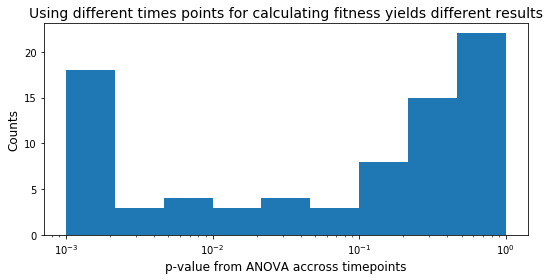

In [16]:
df_singles['p-value'] = TP_ANOVA(df_singles)

## Plotting the change in growth rate over the course of the experiment

This code generates plots comparing the calculated relative growth rate at T0 for each gene to the calculated growth rate at each later timepoint. In our data, the growth rate of many genes decreases with time, at least to a certain point. This is certainly not the case for all genes, however, as some increase or have nonmonotonic sways in growth rate.

/Users/kimreynol/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/kimreynol/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kimreynol/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


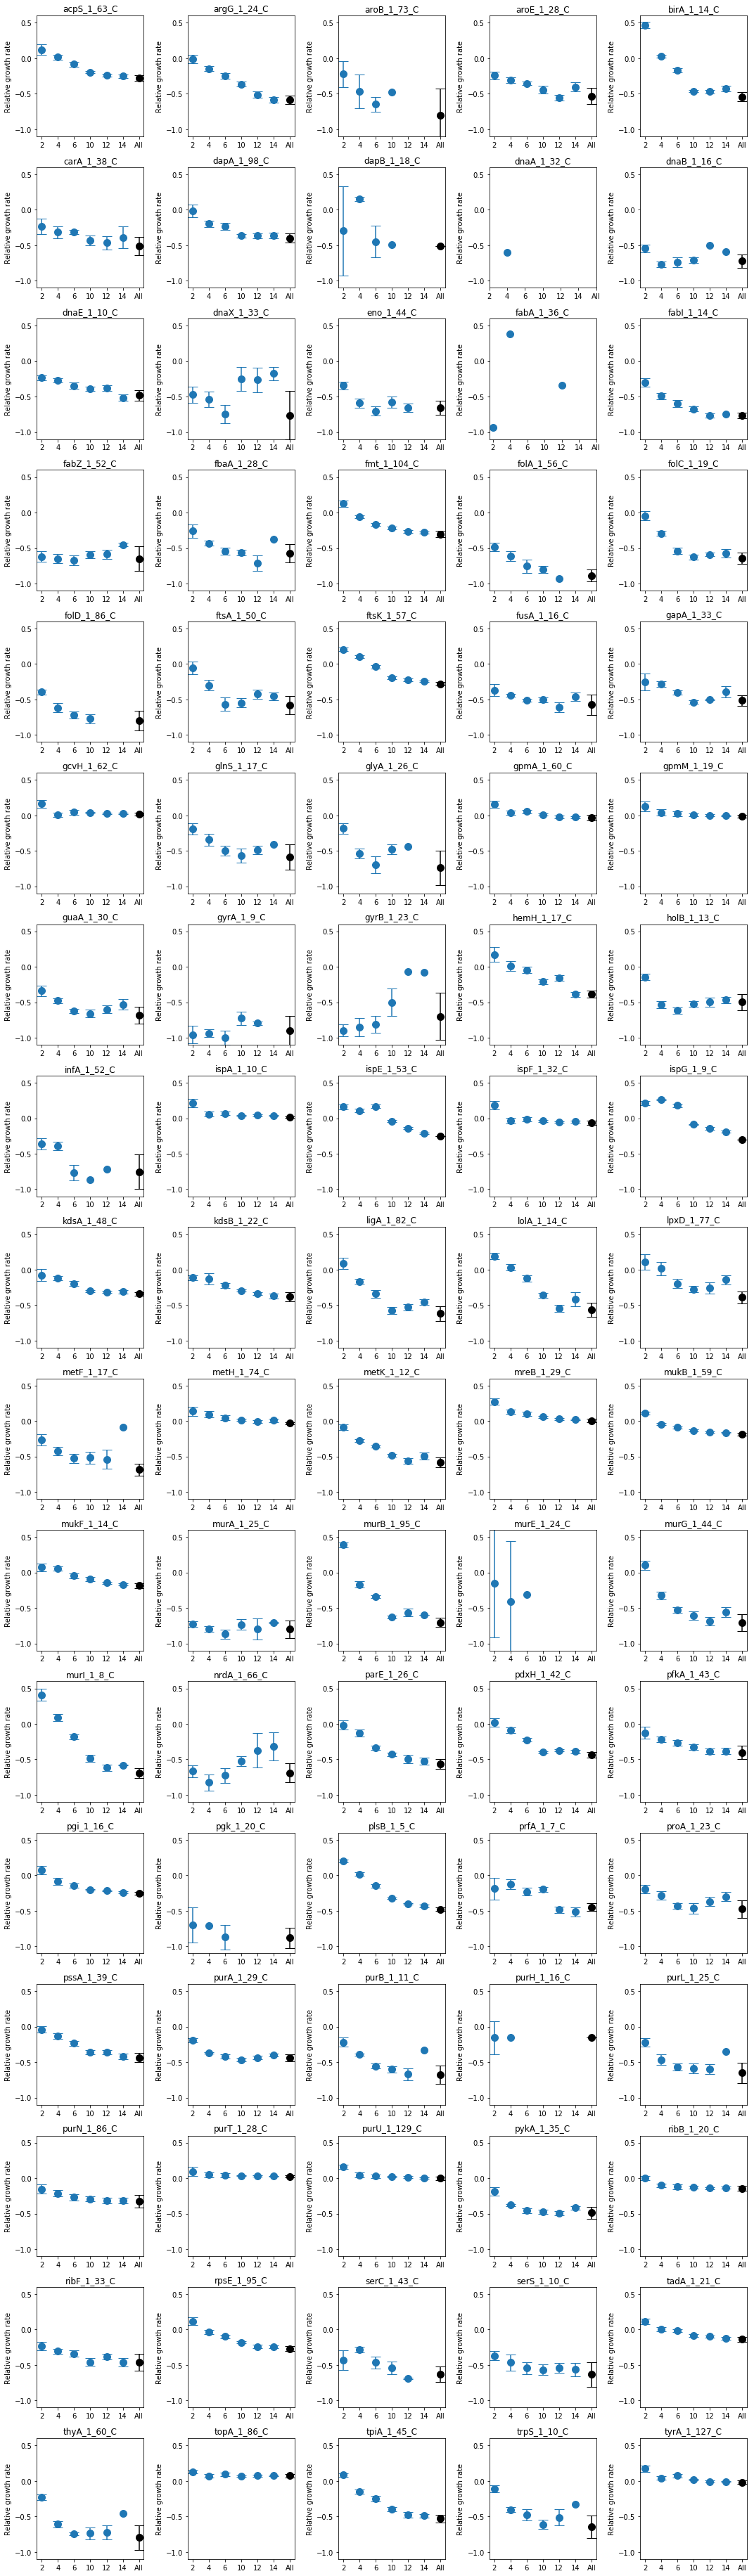

In [17]:
# Plot the growth rate calculated from each individual timepoint (blue) as well as the growth rate calculated using
# a linear fit of all timepoints (black).
TP_plots(df_singles, df_growth, df_singles.index, TPs, media, turb_growth, turb_lib, 'All_plots', norm=False)

## Plotting the change in growth rate from T0

This code generates plots comparing the calculated relative growth rate at T0 for each gene to the calculated growth rate at each later timepoint. As the growth rate at T0 is normalized to 0 independently for each gene, the change in growth rate in each plot is specific to a given gene. In our data, the growth rate of many genes decreases with time, at least to a certain point. This is certainly not the case for all genes, however, as some increase or have nonmonotonic sways in growth rate.

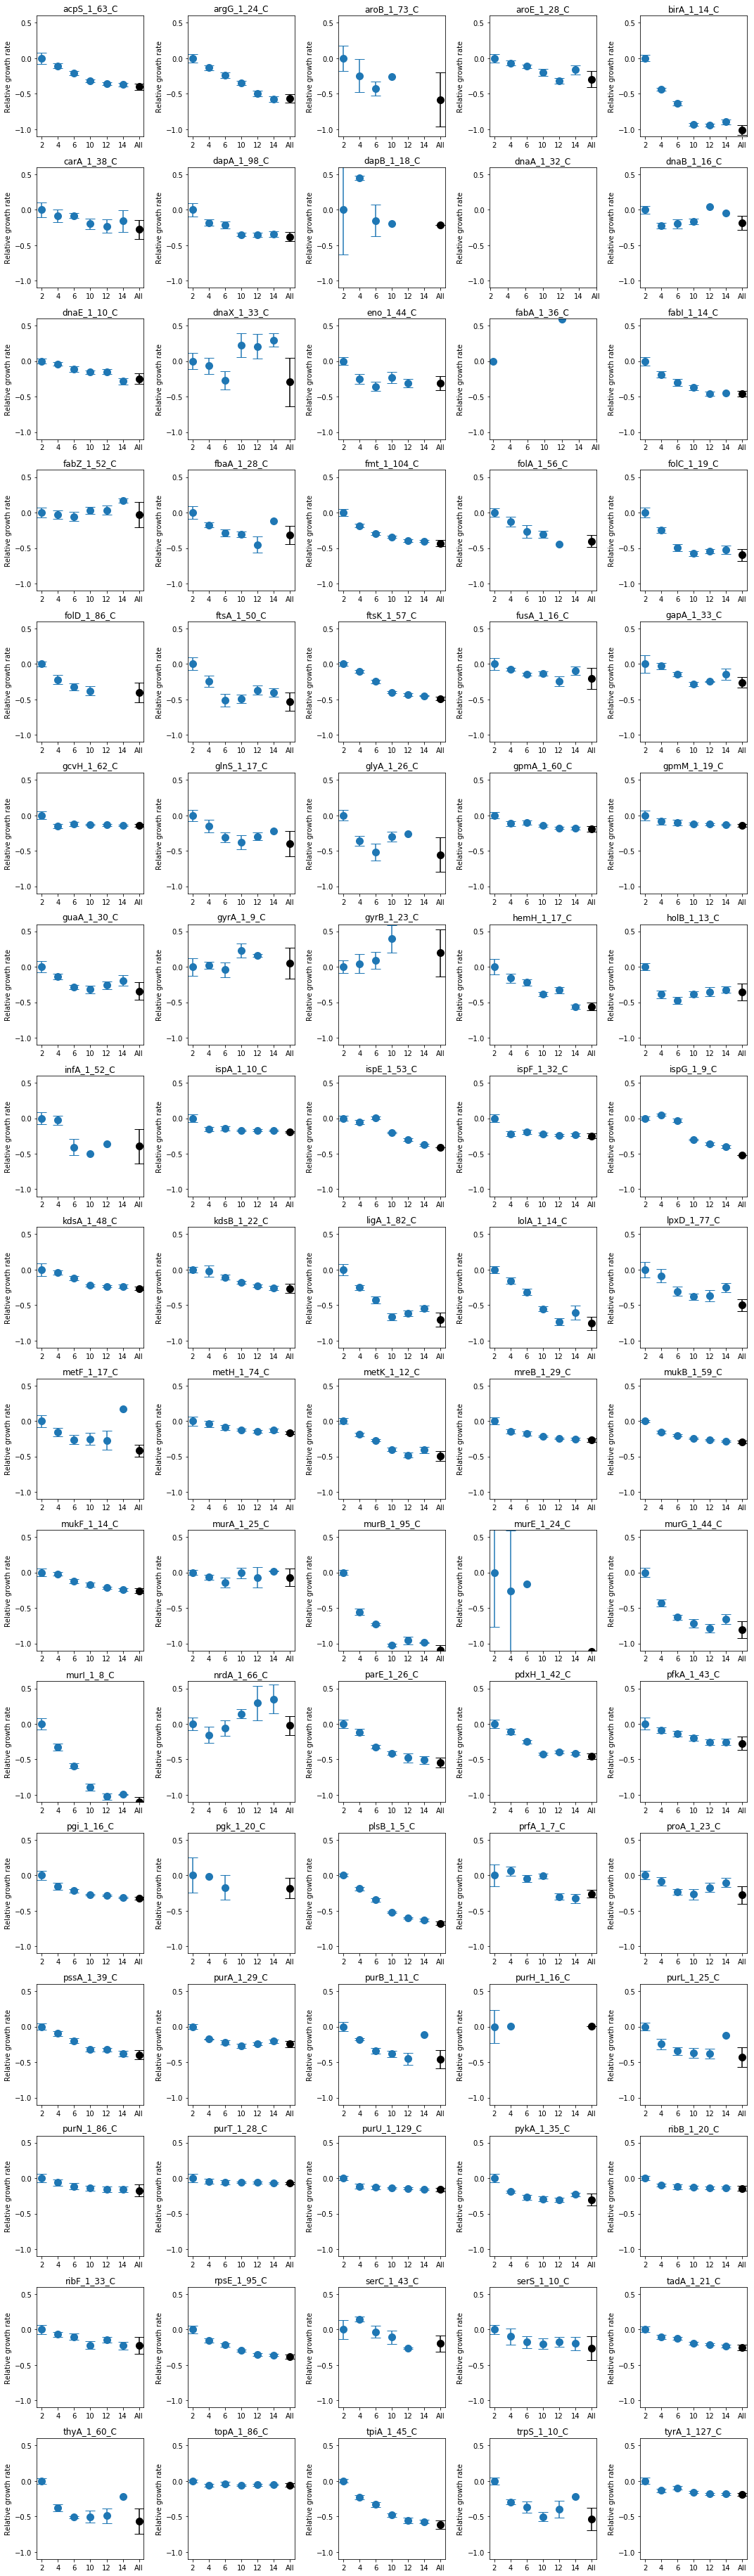

In [18]:
single_array, single_array_nan, single_labels = TP_plots(df_singles, df_growth, df_singles.index, TPs, 
                                                         media, turb_growth, turb_lib, 'All_plots_norm', norm=True)

## Change in relative growth rate over time

This code takes the normalized growth rate data from the second call of TP_plots and plots the change in relative growth rate as a heat map. The two heat maps differ slightly; they deal with guide "fallout" slightly differently. In the case that a guide is present in our early timepoints, but sufficient reads aren't collected in later timepoints (likely due to strong selective pressure against cells expressing these sgRNAs), the first plot carries forward the last successfully measured guide abundance. The second plot does not make this correction, instead not plotting any growth rate information following sgRNA fallout. In both cases, our data recapitulates the trend discussed earlier that in many cases, growth rates tend to decrease over the course of our experiment.

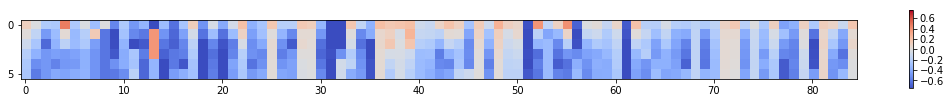

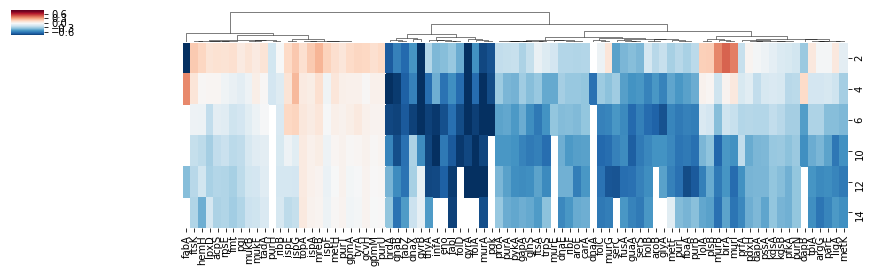

In [19]:
# Heat map of relative growth rate calculated at each timepoint.
# X-axis: Index of targeted gene in single_array
# Y-axis: Index of timepoint used to calculate rel GR from [2, 4, 6, 8, 10, 12, 14]
# Note: if relative GR could not be calculated for a guide at a given timepoint, this point is given the same rel GR
# as the previous timepoint
df_SArray = pd.DataFrame(single_array, index=single_labels)
plt.figure(figsize=(15, 3))
plt.imshow(df_SArray.T, cmap='coolwarm', vmin=-0.75, vmax=0.75)
plt.colorbar(shrink=0.4)
plt.tight_layout()
plt.show()

# Figure 2B
# Heat map of relative growth rate calculated at each timepoint. 
# Organized via linkage analysis of how growth rate changes across timepoints in each gene. Nan values shown in white
# X-axis: Targeted gene
# Y-axis: Time after ATc induction, where the T0 timepoint was taken 3 hours post-induction)
TPs_new = TPs[media]*turb_growth[turb_lib[media]] # Exact timepoints
TPs_FATc = [round(num+3) for num in TPs_new]
Z = linkage(df_SArray, 'ward')

sns.clustermap(single_array_nan.T, method="ward", cmap='RdBu_r', row_cluster=False, col_linkage=Z, 
               figsize=(15, 4), xticklabels=df_SArray.index, yticklabels=TPs[media][1:], linewidths=0, 
               vmin=-0.8, vmax=0.8)
plt.savefig(figure_path + date + '_growthPerTP_Fig2B.pdf', transparent=True)
plt.show()

## Plotting all replicates from selected guides

The list of guides provided in select are selected from our glucose data to represent various behaviors observed throughout this analyis. These behaviors are briefly described below.

pgk - Extreme cell death, with a low relative growth rate, high variance between replicates, and guide fallout at later timepoints

fmt - Stabilization at moderate timepoints

murI - Potential stabilization only at the latest timepoints

aroE - Relatively stable throughout the experiment

nrdA - Nonmonotonic behavior, generally increasing as time goes on, potentially due to an outlier in the replicates

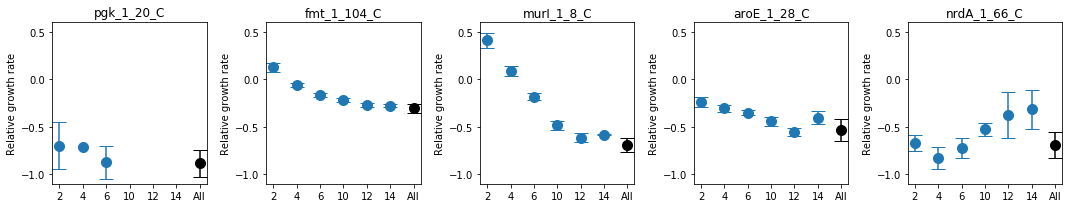

/Users/kimreynol/anaconda2/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/kimreynol/anaconda2/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:126: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/kimreynol/anaconda2/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


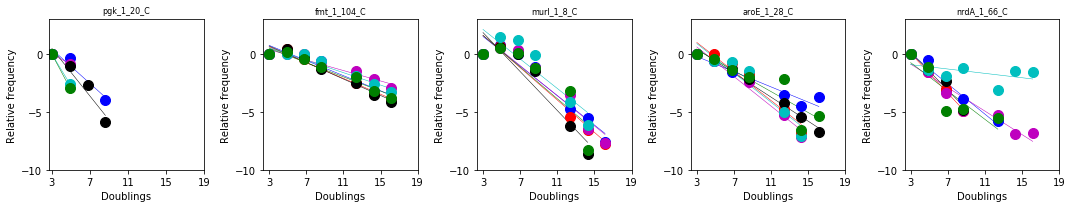

In [20]:
# Figures 2C and 2D
# Examples of glucose timepoint growth data
select = ['pgk_1_20_C', 'fmt_1_104_C', 'murI_1_8_C', 'aroE_1_28_C', 'nrdA_1_66_C']

TP_plots(df_singles, df_growth, select, TPs, media, turb_growth, turb_lib, 'select_timepoint_gr_Fig2C')
growth_rep_plots(df_normed, df_BC, TPs, media, select, turb_growth, turb_lib, figure_path, date, 'select_replicate_gr_Fig2D')

## Stability of growth effect over time

Visualize how often growth effect varies near the end of our experiment. As this involves many tests, correct for significance using Sequential Goodness-of-Fit. In our data, most on-target SG1 growth effects are stable by the end of the experiment.

SGoF correction:
Tests: 71
Significant: 9
Remaining: 2
pval_cutoff: 0.0005524717990754908
Fraction of genes that could be measured and stabilized: 0.87323943662


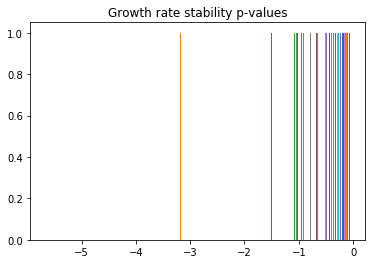

In [21]:
# Stability of growth effect over time
growth_stable = {}
for index in df_singles.index:
    p_sig = []
    p10, p12, p14 = df_singles.loc[index][-4], df_singles.loc[index][-3], df_singles.loc[index][-2]
    if str(p10) != 'nan' and str(p12) != 'nan' and str(p14) != 'nan': 
        stat, pvalue = stats.f_oneway(p10, p12, p14)
        if str(pvalue) != 'nan':
            growth_stable[index] = pvalue
growth_stable = pd.DataFrame.from_dict(growth_stable, orient='index').dropna()

# Pull out relevant data for the chosen group
alpha = 0.05
total_tests = len(growth_stable) # Total tests executed
pvals_list = sorted(growth_stable[0].values)
sig_tests = sum([x < alpha for x in pvals_list]) # Total significant tests, as determined by alpha

print('SGoF correction:')
print('Tests: ' + str(int(total_tests)))
print('Significant: ' + str(sig_tests))

if total_tests > sig_tests:
    b_sig = 0 # Current number of rejected null hypotheses
    R = sig_tests # Current number of remaining tests to re-check
    # Probability that R sig tests could arise from random chance
    p = stats.binom_test(R, n=total_tests, p=alpha, alternative='greater')
    while p < alpha: # Below our confidence threshold
        b_sig +=1 # Fully reject a null
        R -= 1 # Update remaining tests to re-check
        p = stats.binom_test(R, total_tests, p=alpha, alternative='greater')
else:
    print('Cannot use SGoF to correct for significance.')
    b_sig = np.nan

print('Remaining: ' + str(b_sig))
print('pval_cutoff: ' + str(pvals_list[b_sig])) 

print('Fraction of genes that could be measured and stabilized: ' + 
      str(1 - len(growth_stable[growth_stable < 0.05].dropna()) / float(len(growth_stable))))

plt.hist(np.log10(growth_stable))
plt.title('Growth rate stability p-values')
plt.show()

## Parent sgRNA correlation plots

Correlations between fully on-target parent sgRNAs targeting the same gene are expected to be relatively strong. 1_C_C and 2_C_C were designed to be as close together as possible (within our guide design parameters), as as such we see a fairly strong correlation. As 2_C_C is further from the promoter region than 1_C_C, a slope of less than 1 is expected to account for slightly less efficient gene knockdowns for this guide. Similarly, 1_C_C and 3_C_C have more variable correlation, and the slope of the line of best fit is even further from 1 (mirroring 3_C_C's move down the chromosome). 2_C_C and 3_C_C have a similar relationship, albeit somewhat more variable.

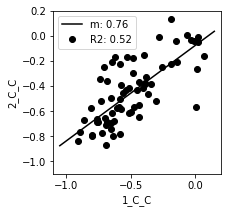

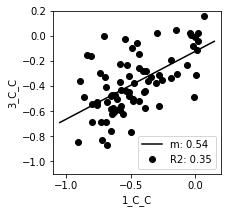

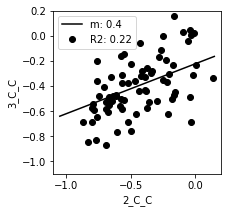

In [22]:
# Figures S5F and S5G
# Pairwise comparisons between the three control (on-target) guides
guide_corr(df_reorder, '1_C_C', '2_C_C', figure_path, date, '_SG1_SG2_Corr_FigS5F')
guide_corr(df_reorder, '1_C_C', '3_C_C', figure_path, date, '_SG1_SG3_Corr_FigS5G')
guide_corr(df_reorder, '2_C_C', '3_C_C', figure_path, date)

## Escaper effects

Plot the change in calculated growth rates and standard error of the mean of growth rate measurements following escaper correction. On this scale of measurement, escapers are common enough to present problems in analysis if they aren't found and removed. These plots visualize escapers, their effects on growth rate, and our data as a whole before and after escaper filtering.

In [23]:
# Reorganize and normalize the data across all barcodes
# Combine all read counts across all barcodes
for i, BC in enumerate(df_BC.keys()):
    if i == 0:
        df_TCounts = df_BC[BC].fillna(0)
    else:
        df_TCounts = df_TCounts + df_BC[BC].fillna(0)
        
# Normalize to T0 and to negC sgRNA
df_Tnorm = df_TCounts.div(df_TCounts['Glu-T0'], axis=0)
df_Tnorm2 = df_Tnorm.div(df_Tnorm.loc['negC_rand_42'], axis=1)
df_Tlog = np.log2(df_Tnorm2)

# Calculate relative growth rate from T0 and T14 hours (Glu-T7 in dataframe)
# Make the growth rate calculation and store in a dataframe
df_growth['GR_T14'] = (df_Tlog['Glu-T7'] - df_Tlog['Glu-T0']) / (TPs['Glu'][-1] - TPs['Glu'][0])
# Remove points that don't have at least 3 replicate measurements per filtering criteria
df_growth_filt = df_growth[df_growth['num-cor'] >=3]

/Users/kimreynol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':


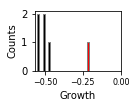

In [24]:
# Figure S4A
# Escaper removal example
plt.figure(figsize=(2, 1.6))
data = list(df_growth.loc['ribF_1_33_C'][0:6].values)
normal = np.concatenate(([data[0]], data[2:]))
escaper = data[1]
plt.hist([normal, escaper], color=['k', 'r'], edgecolor='gray')
plt.xticks([-0.5, -0.25, 0], fontsize=8)
plt.xlabel('Growth')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig(figure_path + date + '_ribF_outlier_FigS4A.pdf', transparent=True)

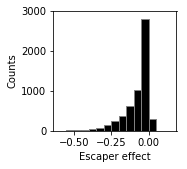

In [25]:
# Figure S4B
plt.figure(figsize=(2.7, 2.45))
# Delta histrogram of growth effects with and without escaper correction
# Effect of escapers on growth rate
delta_GR = pd.DataFrame(df_growth_filt['mean-cor'] - df_growth_filt['GR_T14'])
delta_GR = delta_GR.replace(np.inf, np.nan)
delta_GR.dropna(inplace=True)
STD_dGR = 2 * delta_GR.std() # Standard deviation of delta growth effect distribution
mean_dGR = delta_GR.mean()
bins = np.arange(-0.6, 0.2, 0.05)
plt.hist(delta_GR.values, bins=bins, color='k', edgecolor='grey')
plt.yticks([0, 1000, 2000, 3000])
plt.xlabel('Escaper effect')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig(figure_path + date + '_escaper_correction_hist_FigS4B.pdf', transparent=True)
plt.show()

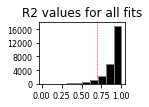

In [26]:
# Figure S4C
# Plot r2 of all fit data with abs(growth rate) > 0.05
plt.figure(figsize=(2, 1.6))
plt.hist(df_r2['0'], edgecolor='grey', color='k')
plt.plot([0.7, 0.7], [0, 19000], '--r', linewidth=0.5)
plt.xticks(np.arange(0, 1.1, 0.25), fontsize=8)
plt.yticks(np.arange(0, 17000, 4000), fontsize=8)
plt.ylim(0, 18000)
plt.title('R2 values for all fits')
plt.tight_layout()
plt.savefig(figure_path + date + '_R2_fit2_FigS4C.pdf', transparent=True)
plt.show()

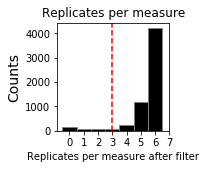

In [27]:
# Figure S4D
plt.figure(figsize=(2.7, 2.45))
bins = np.arange(0, 8, 1)
plt.hist(df_growth['num-cor'], bins=bins, color='k', edgecolor='grey')
plt.xticks(bins+0.5, bins)
plt.axvline(3.5, color='r', ls='--')
plt.xlabel('Replicates per measure after filter', fontsize=10)
plt.ylabel('Counts', fontsize=14)
plt.title('Replicates per measure')
plt.tight_layout()
plt.savefig(figure_path + date + '_rep_number_FigS4D.pdf', transparent=True)
plt.show()

In [28]:
# Identify outliers using quartiles
sort_data = sorted(delta_GR.values)
q1, q3 = np.percentile(sort_data, [25, 75])
# Calculate interquartile ranges
iqr = q3 - q1
# Calculate outlier threshold
thres = q1 -(1.5 * iqr)
# Filter data based on threshold
delta_filt = delta_GR[delta_GR < thres].dropna()

# Largest delta change in growth rate with and without escapers
min_delta = 'serS_3_260_W_MM10'
print('deltaGR > 1 std: ' + str(len(delta_filt)))
print('Fraction negative outliers (escapers) based on quantiles: ' + 
      str(round(np.true_divide(len(delta_filt), len(delta_GR)), 2)))
print('Max fold error:' + 
      str(df_growth_filt['mean-cor'].loc['serS_3_260_W_MM10'] / df_growth_filt['GR_T14'].loc['serS_3_260_W_MM10']))

deltaGR > 1 std: 301
Fraction negative outliers (escapers) based on quantiles: 0.05
Max fold error:9.34771326783276


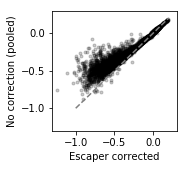

In [29]:
# Figure 2E
# Plot escaper corrected growth rate, vs pooled (no correction) growth rate
plt.figure(figsize=(2.7, 2.45))
ticks = np.arange(-1.0, 0.3, 0.5)
plt.plot(df_growth_filt['mean-cor'], df_growth_filt['GR_T14'], '.k', alpha=0.2)
plt.plot([-1, 0.2], [-1, 0.2], '--', color='grey', label='m=1 line')
plt.yticks(ticks)
plt.xticks(ticks)
plt.ylim(-1.3, 0.3)
plt.xlim(-1.3, 0.3)
plt.xlabel('Escaper corrected')
plt.ylabel('No correction (pooled)')
plt.tight_layout()
plt.savefig(figure_path + date + '_escaper_correction_Fig2E.pdf', transparent=True)
plt.show()

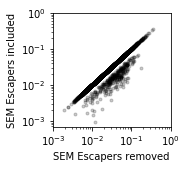

In [30]:
# Figure 2F
# Influence of escapers on measurements error
plt.figure(figsize=(2.7, 2.45))
ticks = [0.001, 0.01, 0.1, 1] # Both x-ticks and y-ticks
plt.plot(df_growth_filt['sem'], df_growth_filt['sem-cor'], '.k', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.yticks(ticks)
plt.xticks(ticks)
plt.xlabel('SEM Escapers removed')
plt.ylabel('SEM Escapers included')
plt.tight_layout()
plt.savefig(figure_path + date + '_escaper_correction_SEM_Fig2F.pdf', transparent=True)
plt.show()

## Correlations between internal barcode replicates after escaper corrections

In [31]:
# Remove escapers from replicates for correlation plots
dict_escap = {} # Holds array of internal replicate growth rates for each sgRNA with escapers removed.
for index in df_growth_filt.index:
    esc_loc = df_growth_filt['escaper-IDX'].loc[index] # Return which barcode (if any) is an escaper
    reps = df_growth_filt.T[index][0:6].values # Internal barcode replicate measurements
    if str(esc_loc) != 'nan': # nan indicates no escaper
        reps[int(esc_loc)] = np.nan # Replace escapers with nan
        dict_escap[index] = reps # Put into dictionary with sgRNA name as key
    else:
        dict_escap[index] = reps # Put into dictionary with sgRNA name as key

df_escap = pd.DataFrame.from_dict(dict_escap).T
df_escap.columns = df_growth_filt.columns[0:6]

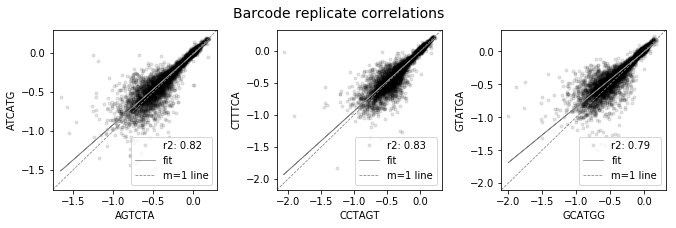

In [32]:
# Figure S5A, S5B, and S5C
# Replicate barcode correlation plots

BC_comp = [['AGTCTA', 'ATCATG'], ['CCTAGT', 'CTTTCA'], ['GCATGG', 'GTATGA']] # Barcodes to be compared (1-2, 3-4, 5-6)
plt.figure(figsize=(9.5, 3))

for i, BC_Pair in enumerate(BC_comp):
    plt.subplot(1, 3, i+1)
    df_GR_temp = df_escap[BC_Pair].dropna() # Pull out growth rates associated with replicates and remove nan
    gr_min = np.amin(np.hstack(df_GR_temp.values)) # Find min and max for plotting
    gr_max = np.amax(np.hstack(df_GR_temp.values))
    x = df_GR_temp[BC_Pair[0]].values
    y = df_GR_temp[BC_Pair[1]].values
    m, b, r_value, p_value, std_err = stats.linregress(x.astype(float), y.astype(float))
    plt.plot(df_GR_temp[BC_Pair[0]], df_GR_temp[BC_Pair[1]], '.k', alpha=0.1, label='r2: '+ str(round(r_value**2, 2)))
    plt.ylim(gr_min - 0.1, gr_max + 0.1)
    plt.xlim(gr_min - 0.1, gr_max + 0.1)
    y_pred = df_GR_temp[BC_Pair[0]]*m + b
    plt.plot(df_GR_temp[BC_Pair[0]], y_pred, '-', color='grey', label='fit', lw=0.75)
    plt.plot([gr_min - 0.1, gr_max + 0.1], [gr_min - 0.1, gr_max + 0.1], '--', color='grey', label='m=1 line', 
             lw=0.75)
    plt.xlabel(BC_Pair[0])
    plt.ylabel(BC_Pair[1])
    plt.legend()
plt.suptitle('Barcode replicate correlations', y=1.04, fontsize=14)
plt.tight_layout()
plt.savefig(figure_path + date + '_' + 'rep_cor_FigS5A-C.pdf', transparent=True)
plt.show()

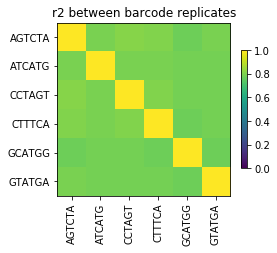

In [33]:
# Figure S5D
# Heatmap of internal replicate correlation R-squared
plt.figure(figsize=(4, 4))
BC_list = np.hstack(BC_comp) # List of barcodes
r2_array = np.zeros((len(BC_list), len(BC_list))) # Holds the R2 data
# Iterate through the barcodes
for i, BC1 in enumerate(BC_list):
    for j, BC2 in enumerate(BC_list):
        df_GR_temp = df_growth[[BC1, BC2]].dropna() # Grab barcodes to correlate
        m, b, r_value, p_value, std_err = stats.linregress(df_GR_temp)
        r2_array[i][j] = round(r_value**2, 2) # Put R2 into dataframe

plt.imshow(r2_array, vmin=0, vmax=1, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.xticks(np.arange(len(BC_list)), BC_list, rotation=90)
plt.yticks(np.arange(len(BC_list)), BC_list)
plt.title('r2 between barcode replicates')
plt.tight_layout()
plt.savefig(figure_path + date + '_' + 'rep_cor_r2_FigS5D.pdf', transparent=True)
plt.show()

## Error in growth rate measurements after quality filtering and escaper corrections

Error, shown here as standard error of the mean, is much lower than the absolute value of calculated growth rate in most of our data, with an average measurement percent error of 9.7%.

/Users/kimreynol/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


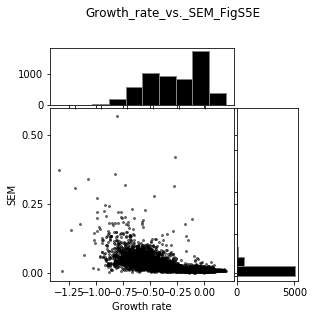

Mean growth rate effect: -0.2857448583816297
Growth rate standard deviation: 0.26964472431703085


In [34]:
# Figure S5E
# Growth rate vs SEM 
ticksX = np.arange(-1.25, 0.1, 0.25)
ticksY = np.arange(0, 1.25, 0.25)
title = 'Growth_rate_vs._SEM_FigS5E'
xlabel = 'Growth rate'
ylabel = 'SEM'
scat_hist(df_growth['mean-cor'], df_growth['sem-cor'], ticksX, ticksY, xlabel, ylabel, title, figure_path, date)
print('Mean growth rate effect: ' + str(np.nanmean(df_growth['mean-cor'])))
print('Growth rate standard deviation: ' + str(np.nanstd(df_growth['mean-cor'])))

In [35]:
# Collect data for calculating percent measurement error
df_err = df_growth[['mean-cor', 'sem-cor']]
# Remove wildtype-like growers and no R2 filter.
PE = abs(((df_err['sem-cor']) / (df_err['mean-cor'])).dropna())
print('Median percent error in growth rate measurements: ' + str(np.round(np.nanmedian(PE) * 100, 1)))

Median percent error in growth rate measurements: 9.7


## Effect of SG1 vs. SG3

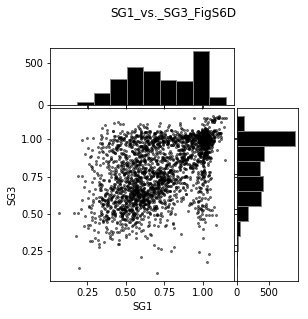

In [36]:
# Figure S6D
# SG1 vs SG3 effects on growth
SG1_all = np.array(list(np.hstack(df_reorder_norm.T[1:35].values)))
SG3_all = np.array(list(np.hstack(df_reorder_norm.T[36:].values)))
ticks = np.arange(0, 1.25, 0.25)
title = 'SG1_vs._SG3_FigS6D'
xlabel = 'SG1'
ylabel = 'SG3'
scat_hist(SG1_all, SG3_all, ticks, ticks, xlabel, ylabel, title, figure_path, date)

## Histograms of parent SG1, SG2, and SG3 effect on growth

In [37]:
# Extract parent sgRNA data.
SG1_P = np.hstack(df_reorder_norm['1_C_C'].values)
SG1_P = SG1_P[~np.isnan(SG1_P)]

SG2_P = np.hstack(df_reorder_norm['2_C_C'].values)
SG2_P = SG2_P[~np.isnan(SG2_P)]

SG3_P = np.hstack(df_reorder_norm['3_C_C'].values)
SG3_P = SG3_P[~np.isnan(SG3_P)]

SG_all = np.array(list(np.hstack(df_reorder_norm.T[1:].values)))
SG_all = SG_all[~np.isnan(SG_all)]

print('Mean growth effect of sgRNAs')
print('SG1: ' + str(round(np.nanmean(SG1_P), 2)))
print('SG2: ' + str(round(np.nanmean(SG2_P), 2)))
print('SG3: ' + str(round(np.nanmean(SG3_P), 2)))
print('All sgRNAs: ' + str(round(np.nanmean(SG_all), 2)))
print('')
print('Std of parent of sgRNAs')
print('SG1: ' + str(round(np.nanstd(SG1_P), 2)))
print('SG2: ' + str(round(np.nanstd(SG2_P), 2)))
print('SG3: ' + str(round(np.nanstd(SG3_P), 2)))
print('All sgRNAs: ' + str(round(np.nanstd(SG_all), 2)))

Mean growth effect of sgRNAs
SG1: 0.62
SG2: 0.63
SG3: 0.7
All sgRNAs: 0.77

Std of parent of sgRNAs
SG1: 0.21
SG2: 0.22
SG3: 0.19
All sgRNAs: 0.22


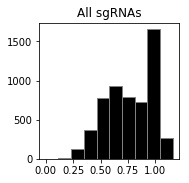

In [38]:
# Figure S6C
# Histrograms of growth rate effects for parent SG1, SG2, and SG3, and all titrating sgRNAs (excludes negC and purE)
plt.figure(figsize=(2.5, 2.5))
xticks = [0, 0.25, .5, 0.75, 1]
plt.hist(SG_all, color='k', edgecolor='grey')
plt.xticks(xticks)
plt.title('All sgRNAs')
plt.savefig(figure_path + date + '_' + 'SG_NGR_all_hist_FigS6C.pdf', transparent=True)
plt.show()

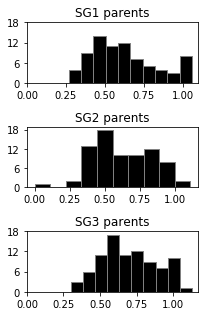

In [39]:
# Fig S6A and S6B
plt.figure(figsize=(3, 4.5))
yticks = np.arange(0, 19, 6)
xticks = [0, 0.25, .5, 0.75, 1]
plt.subplot(311)
plt.hist(SG1_P, color='k', edgecolor='grey')
plt.yticks(yticks)
plt.xticks(xticks)
plt.title('SG1 parents')

plt.subplot(312)
plt.hist(SG2_P, color='k', edgecolor='grey')
plt.yticks(yticks)
plt.xticks(xticks)
plt.title('SG2 parents')

plt.subplot(313)
plt.hist(SG3_P, color='k', edgecolor='grey')
plt.yticks(yticks)
plt.xticks(xticks)
plt.title('SG3 parents')

plt.tight_layout()
plt.savefig(figure_path + date + '_' + 'SG_parent_hist_FigS6A-B.pdf', transparent=True)
plt.show()

## Genes lacking a significant knockdown effect

Some genes, regardless of mismatch number, fail to reproducibly inhibit growth when targeted by our sgRNA library. Two potential reasons for this are most apparent: the first is that these genes aren't essential in our media condition, and the second is that the designed sgRNAs failed to sufficiently knock down protein level of these genes in the time course of our experiment.

In [40]:
# Calculate number of sgRNAs with significant effects on growth
death = df_growth['mean-cor'].loc[death_norm]
df_growth['norm.GR'] = (df_growth['mean-cor']+abs(death)) / abs(death)

df_sig_GR = {}
for index in df_growth.index:
    sp = index.split('_')
    if sp[0] not in df_sig_GR.keys() and sp[0] != 'negC' and sp[0] != 'purE':
        df_sig_GR[sp[0]] = []
    if sp[-1] == 'C':
        GR = df_growth['norm.GR'].loc[index]
        df_sig_GR[sp[0]].append(GR)
            
df_sig_GR = pd.DataFrame.from_dict(df_sig_GR, orient='index')
df_sig_GR['min'] = df_sig_GR.min(axis=1)

print('Genes that do not have significant knockdown effect')
print('Total number: ' + str(len(df_sig_GR[df_sig_GR['min'] >= 0.75])))
print('')
print(df_sig_GR[df_sig_GR['min'] >= 0.75])

Genes that do not have significant knockdown effect
Total number: 18

             0         1         2       min
gcvH  1.016487  0.995060  1.017039  0.995060
ftsK  0.764559       NaN  1.018750  0.764559
nadE  0.822836       NaN       NaN  0.822836
metH  0.976782  0.974421  1.006885  0.974421
ribB  0.882173  0.965753  1.040850  0.882173
ispE  0.794559  0.926310  1.023396  0.794559
ispF  0.947996  1.008976  0.813499  0.813499
ispG  0.754960  0.775158  0.862078  0.754960
ispA  1.015071  0.783572  0.909015  0.783572
tyrA  0.985482  0.935841       NaN  0.935841
pykF  0.894164       NaN       NaN  0.894164
mukF  0.849144  0.819432  0.843989  0.819432
tadA  0.887582  0.833927  0.752517  0.752517
purU  0.997005  0.992747       NaN  0.992747
purT  1.019495  0.957806  0.969079  0.957806
gpmA  0.971540  1.020161       NaN  0.971540
pyrH  0.961752       NaN       NaN  0.961752
topA  1.058837  0.868710  1.129630  0.868710
